### MC/CTRL/IMPL – Off-policy MC control (programming).

Implement off-policy MC control and use it to estimate 𝜋∗
for the grid
world in Exercise gw/simple.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from random import choice, random, randint

In [2]:
class Grid:
    
    def __init__(self, h, w):
        self.w = w
        self.h = h
        
        self.actions = [0, 1, 2, 3] #up, down, left, right
        
        self.states = [s for s in range(h*w)]
        self.terminal = [0, (h*w-1)]
        
        #### state numbering ####
        # 0  1  2  3  4  5 
        # 6  7  8  9  10 11
        # 12 13 14 15 16 17
        
        # 0 and 17 are the final states
        #### state numbering ####
        
    def state_coordinates(self, s):
        return (s // self.w, s % self.w)
    
    def visualize(self):
        vis = np.ones((self.h+1, self.w))
        
        for s in self.states:
            vis[self.state_coordinates(s)] = -1
            
        for s in self.terminal:
            vis[self.state_coordinates(s)] = 1
        
        plt.imshow(vis)
        
    def step(self, s, a):
        assert s in (self.states), f'{s=} not valid.'
        
        action_values = [-self.w, +self.w, -1, +1]
        sprime = s + action_values[a]
        
        if (s // self.w) != (sprime // self.w) and a > 1: # out horizontally
            return s, -1
        elif sprime not in self.states: # out vertically
            return s, -1
        else:
            return sprime, -1
        
def get_greedy_action(world, Q, s):
    """ Get greedy action from Q as one hot vector """
    A = len(world.actions) # num of actions, i.e. |A(S)|
    return np.eye(A)[Q[s, :].argmax()] 

def get_epsilon_soft(world, π, ϵ):
    """ Get ϵ soft π policy """
    A = len(world.actions)
    b = (np.ones(π.shape) * ϵ/A) + (π * (1-ϵ))
    return b

def generate_episode(world, b, s, t): 
    if s in world.terminal:
        return [], [], []
    
    probs = b[s, :]
    a = np.random.choice(world.actions, p=probs)
    s_prime, r = world.step(s, a)
    
    states, actions, rewards = [s], [a], [r]
    
    if t > 1:                    
        s_next, a_next, r_next = generate_episode(world, b, s_prime, t-1)

        states = [s] + s_next
        actions = [a] + a_next
        rewards = [r] + r_next

    return states, actions, rewards

def off_policy_MC_control(world, ϵ=0.1, T=20, γ=0.9, num_episodes=100):
    A = len(world.actions)
    S = len(world.states)

    π = np.random.random((S, A))
    Q = np.random.random((S, A))
    for t in world.terminal:
        Q[t] = 0
        
    C = np.zeros((S, A))

    # initialize π greedily with respect to Q
    for s in world.states:
        π[s, :] = get_greedy_action(world, Q, s)

    print('loop episodes')
    for ep in tqdm(range(num_episodes)):
    #         b = softmax(np.ones((4, w, h))) # equiprob
        b = get_epsilon_soft(world, π, ϵ) # create soft policy from π

        s0 = choice(world.states)
        states, actions, rewards = generate_episode(world, b, s0, T) # generate episode from b

        G = 0
        W = 1

        for n in range(len(states)-1, -1, -1):
            s = states[n]
            a = actions[n]
            r = rewards[n]

            G = γ*G + r 
            C[s, a] = C[s, a] + W
            
            Q[s, a] = Q[s, a] + W/C[s, a] * (G - Q[s, a])
            
            π[s, :] = get_greedy_action(world, Q, s) # pick π greedy
            if a != π[s, :].argmax():
                break
            else:
                W = W/b[s, a]
    
    return π, Q, C

In [3]:
h, w = 4, 4

grid = Grid(h,w)

π_out, Q_out, C_out = off_policy_MC_control(grid, ϵ=0.1, T=30, γ=1.0, num_episodes=100000)

V_out = np.ones((h, w))
for s in grid.states:
    s_coord = grid.state_coordinates(s)
    V_out[s_coord] = (π_out*Q_out).sum(axis=-1)[s]
    
print(V_out.round(decimals=1))

loop episodes


/tmp/ipykernel_250/2051946136.py:93: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for ep in tqdm(range(num_episodes)):


  0%|          | 0/100000 [00:00<?, ?it/s]

[[ 0. -1. -2. -3.]
 [-1. -2. -3. -2.]
 [-2. -3. -2. -1.]
 [-3. -2. -1.  0.]]


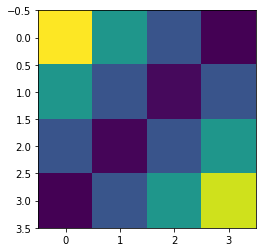

In [18]:
plt.imshow(V_out)

In [5]:
V_out

array([[ 0.        , -1.        , -1.99966095, -2.99308238],
       [-1.        , -1.99978813, -2.98525858, -1.99970132],
       [-1.99955165, -2.96763169, -1.99975908, -1.        ],
       [-2.98685481, -1.999735  , -1.        ,  0.        ]])

down


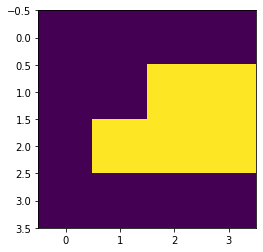

In [15]:
a = 1
pi_out = np.ones((h, w))
for s in grid.states:
    s_coord = grid.state_coordinates(s)
    pi_out[s_coord] = π_out[s,a]
print(f"{['up', 'down', 'left', 'right'][a]}")
plt.imshow(pi_out)